## Experiment Setup

In [1]:
import sys
sys.path.append("/home/sepiabrown/MS-Thesis/")

In [2]:
import time
import datetime
import os
import sys
import itertools

%load_ext autoreload
%autoreload 2

random_seed = 682

In [3]:
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt
import tqdm
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC


from MC_Dropout import models, datasets
from MC_Dropout.models import utils


%matplotlib inline


use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    
    
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True 

    
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

/nix/store/a94hfbcj37fkwncciik0shqf8z8liljc-python3-3.9.11-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Toy dataset settings

In [4]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""


dataset_toy_random_seed = 691


dataset_toy_size = 20
random_x = True


dataset_toy_x_low = -4
dataset_toy_x_high = 4


dataset_toy_y_noise_mean = 0
dataset_toy_y_noise_std = 9


dataset_toy_more_noise_x_from=None
dataset_toy_more_noise_x_to=dataset_toy_x_high
dataset_toy_more_noise_y_from=50
dataset_toy_more_noise_y_to=100

### MC dropout parameters

In [5]:
"""
MC Dropout related
"""


dropout_rate = 0.1


length_scale = 0.01


tau = 0.25


reg_strength = utils.reg_strength(dropout_rate, length_scale, dataset_toy_size, tau)

print('reg_strength = ' + str(reg_strength))


n_epochs = 40000


learning_rate = 0.001


loss_function_type = 'log_gaussian_loss'


learn_hetero_noise = True


n_predictions = 1000

reg_strength = tensor(9.0000e-06, dtype=torch.float64)


### Directory path to save results

In [6]:

test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')


test_results_path = os.path.join(
    './test_results2',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(length_scale)
        + '_' + str(tau)
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)


os.makedirs(test_results_path, exist_ok=True)

## Prepare data

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    random_x=random_x,
    y_noise_mean=dataset_toy_y_noise_mean,
    y_noise_std=dataset_toy_y_noise_std,
    more_noise_x_from=dataset_toy_more_noise_x_from,
    more_noise_x_to=dataset_toy_more_noise_x_to,
    more_noise_y_from=dataset_toy_more_noise_y_from,
    more_noise_y_to=dataset_toy_more_noise_y_to,
)


X_test = torch.linspace(dataset_toy_x_low-5, dataset_toy_x_high+5, 100).reshape(100, 1)
y_test = torch.pow(X_test, 3)


X_test = X_test.to(torch_device)
y_test = y_test.to(torch_device)


X_test_cpu = X_test.cpu()


print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [8]:
uncertainty_methods = {}


do_mc_dropout = True

if do_mc_dropout:
    uncertainty_methods['mc_dropout_relu'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        learn_hetero=learn_hetero_noise,
    )

do_vi = False

if do_vi:
    uncertainty_methods['vi'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )


do_hmc = False

if do_hmc:
    uncertainty_methods['hmc'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    
    print("Now running " + str(key))
    
    
    network.to(torch_device)

    print(network)
    print()

    train_loader = DataLoader(dataset, batch_size=128)
    

    if isinstance(network, models.FCNet):
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

    elif isinstance(network, models.FCNetPyro):
        pyro.clear_param_store()

        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=10000)

    network.train()

    tic = time.time()
    
    if key == 'hmc':
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        progress_bar = tqdm.tqdm(range(n_epochs))

        for epoch in progress_bar:

            for i, data in enumerate(train_loader):
                inputs, targets = data

                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNet):
                    optimizer.zero_grad()

                    outputs, noises = network(inputs)

                    if loss_function_type == 'mse_loss':
                        total_loss = torch.nn.MSELoss()(outputs, targets)
                    elif loss_function_type == 'log_gaussian_loss':
                        total_loss = utils.log_gaussian_loss(outputs, targets, noises.exp())

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    
                    total_loss = svi.step(inputs, targets)

            progress_bar.set_description("loss: %5.4f" % total_loss)
            
    toc = time.time()

    print("final loss = " + str(total_loss))            

    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout_relu
FCNet(
  (input): ModuleDict(
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (nonlinear): ReLU()
  )
  (output_noise): Linear(in_features=100, out_features=1, bias=True)
  (output): ModuleDict(
    (linear): Linear(in_features=100, out_features=1, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)



loss: 65.3430: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [02:57<00:00, 224.89it/s]


final loss = tensor(65.3430, grad_fn=<NegBackward0>)
training time = 177.87416219711304 seconds



## Plot

testing time = 0.32800912857055664 seconds

Mean = tensor([-1.4169e+02, -1.3893e+02, -1.3149e+02, -1.2908e+02, -1.2661e+02,
        -1.2431e+02, -1.1969e+02, -1.1566e+02, -1.1381e+02, -1.0903e+02,
        -1.0589e+02, -1.0061e+02, -9.8443e+01, -9.6579e+01, -9.1287e+01,
        -8.6293e+01, -8.4017e+01, -7.9895e+01, -7.7086e+01, -7.3939e+01,
        -7.1716e+01, -6.7733e+01, -6.3305e+01, -6.1401e+01, -5.7374e+01,
        -5.3552e+01, -4.9497e+01, -4.5697e+01, -4.3914e+01, -4.0101e+01,
        -3.6541e+01, -3.2522e+01, -2.9240e+01, -2.5800e+01, -2.2995e+01,
        -1.9152e+01, -1.5575e+01, -1.2251e+01, -8.6816e+00, -5.3157e+00,
        -3.0741e+00, -3.1369e+00, -3.2245e+00, -2.9537e+00, -2.4006e+00,
        -1.8542e+00, -1.1993e+00, -6.4879e-01, -7.0997e-02,  4.9795e-01,
         1.0777e+00,  1.6481e+00,  2.2454e+00,  2.5865e+00,  2.4902e+00,
         2.4748e+00,  2.3993e+00,  2.3801e+00,  2.6530e+00,  3.2189e+00,
         3.7987e+00,  4.3092e+00,  4.7866e+00,  5.2151e+00,  6.3583e+00,


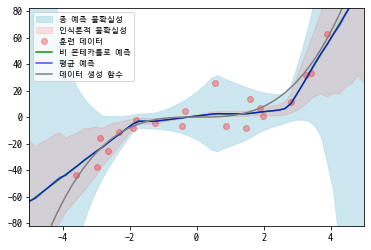

In [35]:
for key, network in uncertainty_methods.items():

    network.eval()

    tic_testing = time.time()
    
    predictions_non_mc, _ = network(X_test)

    predictions, mean, var, noises, metrics = network.predict_dist(
        X_test, n_predictions,
        y_test=y_test,
        tau=torch.tensor(tau, dtype=torch.float))
    
    toc_testing = time.time()

    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    predictions_non_mc = predictions_non_mc.cpu()
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    noises = noises.cpu()

    total_uncertainty = var + noises

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    print("Noise = " + str(noises.flatten()))
    
    if len(metrics) > 0:
        for metric_key, value in metrics.items():
            print(str(metric_key) + " = " + str(value))
        print()
            
    plt.rc('font', family='D2Coding')
    
    plt.figure()
    
    plt.xlim(dataset_toy_x_low-1, dataset_toy_x_high+1)
    
    plot_ylim_low = dataset_toy_x_low ** 3 - 2 * dataset_toy_y_noise_std
    plot_ylim_high = dataset_toy_x_high ** 3 + 2 * dataset_toy_y_noise_std
    
    plt.ylim(plot_ylim_low, plot_ylim_high)
    
    plt.fill_between(
       X_test_cpu.flatten(), 
       (mean.detach().numpy() - 2*torch.sqrt(total_uncertainty).detach().numpy()).flatten(),
       (mean.detach().numpy() + 2*torch.sqrt(total_uncertainty).detach().numpy()).flatten(),
       color='lightblue', alpha=0.6, label="총 예측 불확실성")
    
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='red', alpha=0.1, label="인식론적 불확실성")

    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='훈련 데이터', alpha=0.3)

    plt.plot(X_test_cpu, predictions_non_mc.detach().numpy(), 'green', label='비 몬테카를로 예측', alpha=0.9)    
    
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='평균 예측', alpha=0.7)
    
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='데이터 생성 함수')    
    
    plt.legend(loc=2, prop={'size': 8})
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'), dpi=200)
    
    plt.show()